/Users/windy/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/windy/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49
Generation 50
Generation 51
Generation 52
Generation 53
Generation 54
Generation 55
Generation 56
Generation 57
Generation 58
Generation 59
Generation 60
Generation 61
Generation 62
Generation 63
Generation 64
Generation 65
Generation 66
Generation 67
Generation 68
Generation 69
Generation 70
Generation 71
Generation 72
G

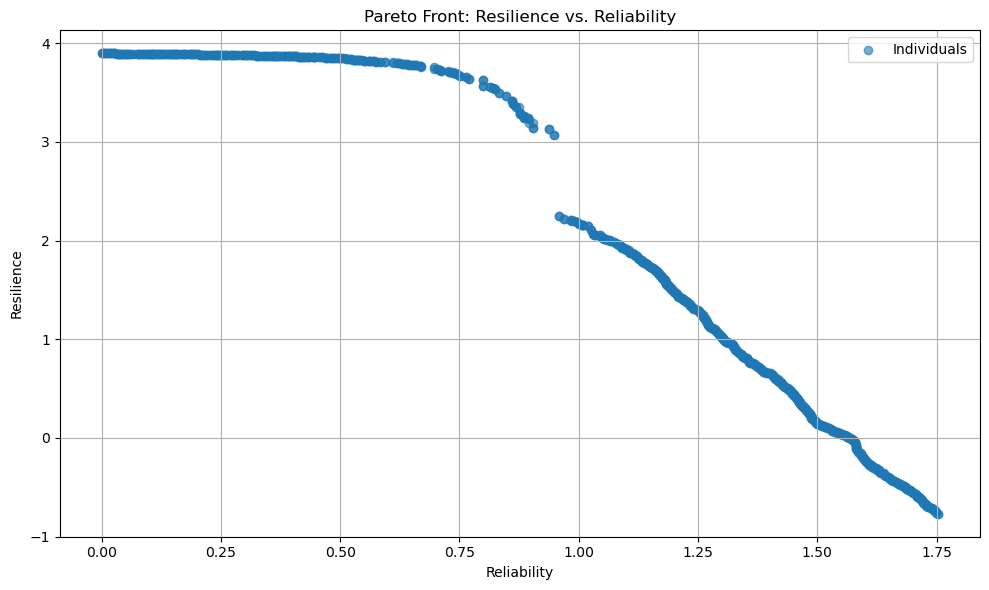

In [ ]:
"""
Genetic Algorithm for Brazil Drought Contingency Plan
Tomás Schmieder & Maoz Bizan
CEE 4200
"""

# importing what we need, if you don't have it then use pip install the module in terminal
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from deap import base, creator, tools


# load the dataset, which has historical values for everything
# you will need to replace the file path
file_path = '/Users/windy/desktop/data.csv'
df = pd.read_csv(file_path)

# constants
s_c = 337                       # critical storage, 20% of max
D = 2.8512                      # demand of SPMR, mcm/day
max_storage = 1685              # max storage mcm
initial_storage = 1023.8908     # intial storage mcm


df["Change in time (days)"] = df["Change in time (days)"].fillna(method='ffill')
df["Combined Precipitation (mcm)"] = df["Combined Precipitation (mcm)"].fillna(0)
df["Inverted Inflow (mcm)"] = df["Inverted Inflow (mcm)"].fillna(0)

def percentfull(storage, maximum_storage):
    return (storage / maximum_storage) * 100

# contingency plan 
def revised_outflow_policy(storage_percentage, t1, o1, t2, o2, t3, o3, t4, o4, o5):
    if storage_percentage >= t1:
        return o1
    elif t2 <= storage_percentage < t1:
        return o2
    elif t3 <= storage_percentage < t2:
        return o3
    elif t4 <= storage_percentage < t3:
        return o4
    else:
        return o5

# simulated contingency policy
def simulate_storage_with_policy(params):
    t1, o1, t2, o2, t3, o3, t4, o4, o5 = params
    # constraints / penalties
    if not (t1 > t2 > t3 > t4):  # thresholds need to be consistent
        return -1e6, -1e6
    if not all(0 <= o <= 5 for o in [o1, o2, o3, o4, o5]):  # realistic outflows
        return -1e6, -1e6

    current_storage = initial_storage
    reliability_values = []
    resilience_values = []

    for i in range(148):
        precip = df["Combined Precipitation (mcm)"].iloc[i]
        inflow = df["Inverted Inflow (mcm)"].iloc[i]
        change_time = df["Change in time (days)"].iloc[i]
        storage_percentage = percentfull(current_storage, max_storage)
        outflow = revised_outflow_policy(storage_percentage, t1, o1, t2, o2, t3, o3, t4, o4, o5)
        outflow_mcm = outflow * change_time
        next_storage = current_storage + precip + inflow - outflow_mcm
        next_storage = max(0, min(next_storage, max_storage))
        reliability_values.append(reliability(outflow, D))
        resilience_values.append(resilience(current_storage, s_c))
        current_storage = next_storage
    avg_reliability = np.mean(reliability_values)
    avg_resilience = np.mean(resilience_values)

    # setting a cap for reliability and resilience so we can get realistic results
    avg_reliability = min(avg_reliability, 5)
    avg_resilience = min(avg_resilience, 5)

    return avg_reliability, avg_resilience

def reliability(u, D):
    return u / D

def resilience(s_t, s_c):
    return (s_t - s_c) / s_c if s_c != 0 else float('nan')  # DON'T REMOVE OR IT MIGHT BREAK, DIVIDE BY ZERO ERROR

# deap initialization 
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0))  # we want to maximize both values
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        lambda: random.uniform(50, 70),     # Threshold 1
        lambda: random.uniform(0, 5),       # Outflow 1
        lambda: random.uniform(30, 50),     # Threshold 2
        lambda: random.uniform(0, 5),       # Outflow 2
        lambda: random.uniform(20, 40),     # Threshold 3
        lambda: random.uniform(0, 5),       # Outflow 3
        lambda: random.uniform(10, 30),     # Threshold 4
        lambda: random.uniform(0, 5),       # Outflow 4
        lambda: random.uniform(0, 5),       # Outflow 5
    ),
    n=1,
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", simulate_storage_with_policy)

# ga parameters
population_size = 1000 
generations = 250
mutation_prob = 0.2
crossover_prob = 0.7

# initial population
population = toolbox.population(n=population_size)
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# ga start
for gen in range(generations):
    print(f"Generation {gen + 1}")
    offspring = tools.selNSGA2(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < crossover_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # mutation
    for mutant in offspring:
        if random.random() < mutation_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    population[:] = tools.selNSGA2(population + offspring, population_size)

# data
data = []
for ind in population:
    reliability, resilience = ind.fitness.values
    thresholds = ind[:5]
    outflows = ind[5:]
    data.append({
        "Reliability": reliability,
        "Resilience": resilience,
        "Thresholds": thresholds,
        "Outflows": outflows
    })

df_plot = pd.DataFrame(data)

# plotly plot
fig = px.scatter(
    df_plot,
    x="Reliability",
    y="Resilience",
    hover_data=["Thresholds", "Outflows"],
    title="Pareto Front: Resilience vs. Reliability (Plotly)",
    labels={"Reliability": "Reliability", "Resilience": "Resilience"}
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.show()

# matplotlib plot
plt.figure(figsize=(10, 6))
plt.scatter(df_plot["Reliability"], df_plot["Resilience"], alpha=0.6, label="Individuals")
plt.title("Pareto Front: Resilience vs. Reliability")
plt.xlabel("Reliability")
plt.ylabel("Resilience")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Best Individual Based on Normalized Distance to Ideal Point:
Reliability                                                        0.938371
Resilience                                                         3.127576
Thresholds                [82.13339374183226, 4.9653883108875645, 38.254...
Outflows                  [2.961250656216124, 10.033240426398493, 2.6789...
Distance to Utopia                                                  1.37411
Normalized Reliability                                             0.535201
Normalized Resilience                                              0.802586
Distance to Ideal                                                  0.504985
Name: 6, dtype: object


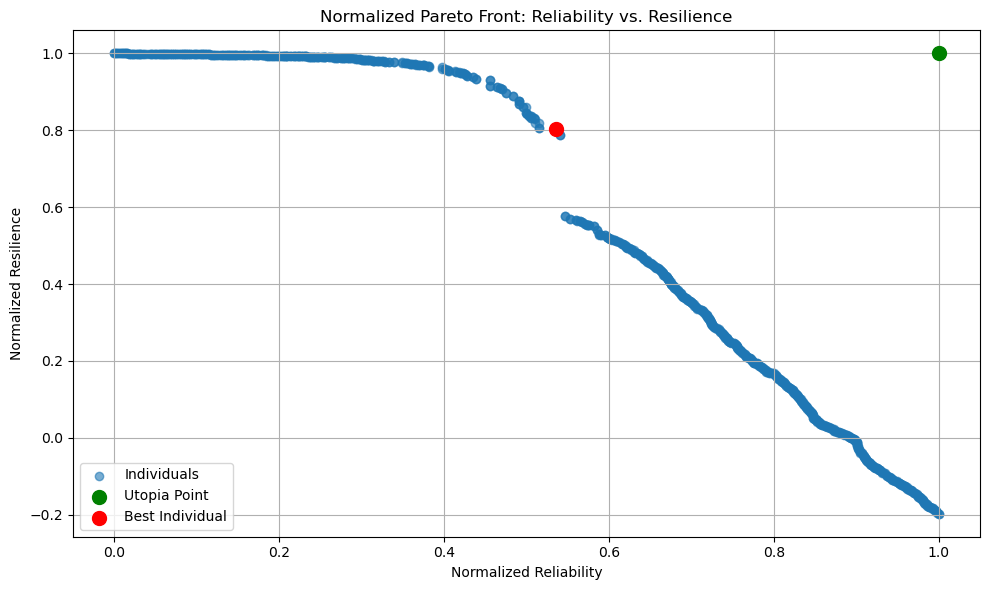

In [ ]:
# how can we find best individual if we dont have utopia point?
# this normalizes the individuals to be between 0 and 1 so we can find the best individual and define utopia as 1,1
df_plot["Normalized Reliability"] = df_plot["Reliability"] / df_plot["Reliability"].max()
df_plot["Normalized Resilience"] = df_plot["Resilience"] / df_plot["Resilience"].max()

# utopia point is 1,1 as we have normalized it
utopia_point = (1, 1)

# calculating the normalized distance
df_plot["Distance to Ideal"] = np.sqrt(
    (df_plot["Normalized Reliability"] - utopia_point[0]) ** 2 +
    (df_plot["Normalized Resilience"] - utopia_point[1]) ** 2
)

# distance finds best point
best_individual_idx = df_plot["Distance to Ideal"].idxmin()
best_individual = df_plot.iloc[best_individual_idx]
print("Best Individual Based on Normalized Distance to Ideal Point:")
print(best_individual)

# LOL ITS THE SAME POINT I CHOSE

# plotting
plt.figure(figsize=(10, 6))
plt.scatter(
    df_plot["Normalized Reliability"],
    df_plot["Normalized Resilience"],
    alpha=0.6,
    label="Individuals"
)
plt.scatter(
    utopia_point[0],
    utopia_point[1],
    color='green',
    label="Utopia Point",
    zorder=5,
    s=100
)
plt.scatter(
    df_plot.loc[best_individual_idx, "Normalized Reliability"],
    df_plot.loc[best_individual_idx, "Normalized Resilience"],
    color='red',
    label="Best Individual",
    zorder=5,
    s=100
)

plt.title("Normalized Pareto Front: Reliability vs. Resilience")
plt.xlabel("Normalized Reliability")
plt.ylabel("Normalized Resilience")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
